<a href="https://colab.research.google.com/github/PacktPublishing/Machine-Learning-for-Time-Series-with-Python/blob/master/chapter7/KNN_with_dynamic_DTW.ipynb" target="_parent\"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tsfresh "statsmodels<=0.12"

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
  Using cached statsmodels-0.12.0.tar.gz (17.5 MB)
  Installing build dependencies ... error
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [104 lines of output]
      Ignoring numpy: markers 'python_version == "3.6"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.7"' don't match your environment
        Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
        Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
        Using cached cython-3.1.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.5 kB)
        Using cached numpy-1.17.5.zip (6.4 MB)
        Preparing metadata (setup.py): started
        Preparing metadata (setup.py): finished with status 'done'
        Using cached scipy-1.15.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_6

In [2]:
!pip install tslearn

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "17"

In [4]:
from tsfresh.examples import load_robot_execution_failures
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures

download_robot_execution_failures()
df_ts, y = load_robot_execution_failures()

In [5]:
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

extracted_features = impute(extract_features(df_ts, column_id="id", column_sort="time"))
features_filtered = select_features(extracted_features, y)

Feature Extraction: 100%|██████████| 66/66 [00:02<00:00, 31.49it/s]
/root/miniconda3/envs/TimeSeries/lib/python3.12/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_z__partial_autocorrelation__lag_7'
 'F_z__partial_autocorrelation__lag_8'
 'F_z__partial_autocorrelation__lag_9' ...
 'F_y__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'F_y__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'F_y__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


In [6]:
from tsfresh.transformers import RelevantFeatureAugmenter
import pandas as pd

X = pd.DataFrame(index=y.index)
TRAINING_SIZE = (len(X) // 10) * 8
augmenter = RelevantFeatureAugmenter(column_id='id', column_sort='time')
augmenter.set_timeseries_container(df_ts[:TRAINING_SIZE])
augmenter.fit(X[:TRAINING_SIZE], y[:TRAINING_SIZE])
X_transformed = augmenter.transform(X)

Feature Extraction: 100%|██████████| 30/30 [00:00<00:00, 196.63it/s]
/root/miniconda3/envs/TimeSeries/lib/python3.12/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['T_y__partial_autocorrelation__lag_7'
 'T_y__partial_autocorrelation__lag_8'
 'T_y__partial_autocorrelation__lag_9' ...
 'T_x__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_x__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_x__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(
Feature Extraction: 100%|██████████| 30/30 [00:00<00:00, 9634.70it/s]


In [7]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from tslearn.neighbors import KNeighborsTimeSeriesClassifier

knn = KNeighborsTimeSeriesClassifier()
param_search = {
    'metric' : ['dtw'],  # ctw', 'dtw', "softdtw"], # TSLEARN_VALID_METRICS}
    'n_neighbors': [1, 2, 3]
}
#  'param_grid': {'metric': ['ctw', 'dtw', 'gak', 'sax', 'softdtw', 'lcss']},
tscv = TimeSeriesSplit(n_splits=2)

gsearch = GridSearchCV(
    estimator=knn,
    cv=tscv,
    param_grid=param_search
)
gsearch.fit(
    features_filtered,
    y
)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=KNeighborsTimeSeriesClassifier(),
             param_grid={'metric': ['dtw'], 'n_neighbors': [1, 2, 3]})

In [8]:
# Adapted from comments on this discussion thread on stackoverflow: https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv
import seaborn as sns
import pandas as pd

def plot_cv_results(cv_results, param_x, param_z, metric='mean_test_score'):
    """
    cv_results - cv_results_ attribute of a GridSearchCV instance (or similar)
    param_x - name of grid search parameter to plot on x axis
    param_z - name of grid search parameter to plot by line color
    """
    cv_results = pd.DataFrame(cv_results)
    col_x = 'param_' + param_x
    col_z = 'param_' + param_z
    fig, ax = plt.subplots(1, 1, figsize=(11, 8))
    sns.pointplot(x=col_x, y=metric, hue=col_z, data=cv_results, ci=99, n_boot=64, ax=ax)
    ax.set_title("CV Grid Search Results")
    ax.set_xlabel(param_x)
    ax.set_ylabel(metric)
    ax.legend(title=param_z)
    return fig


/tmp/ipykernel_104804/2258186687.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 99)` for the same effect.

  sns.pointplot(x=col_x, y=metric, hue=col_z, data=cv_results, ci=99, n_boot=64, ax=ax)


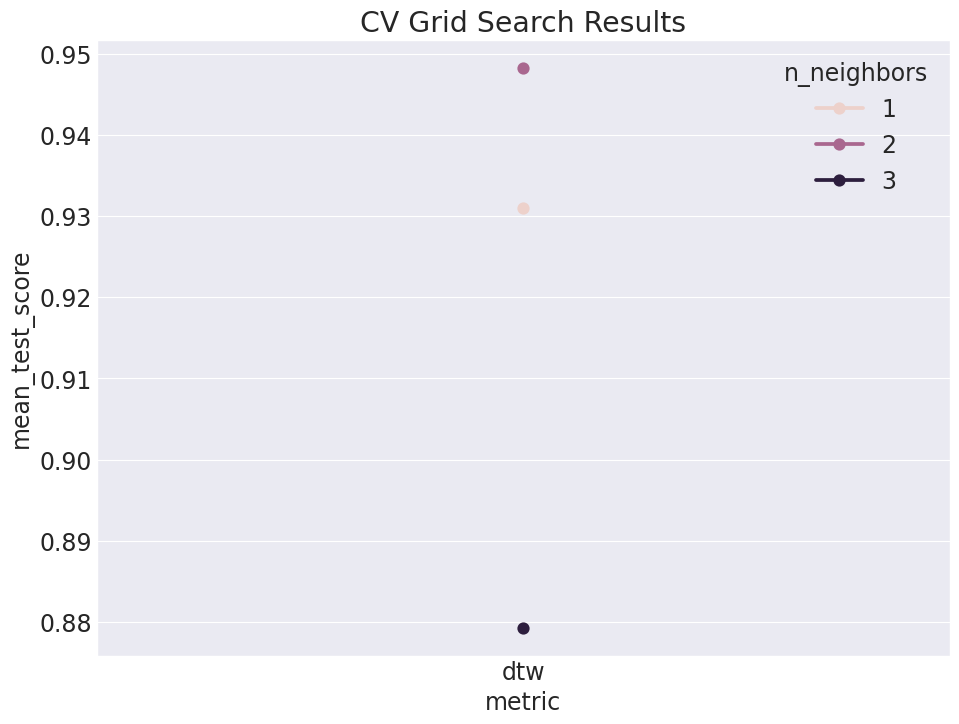

In [9]:
fig = plot_cv_results(gsearch.cv_results_, 'metric', 'n_neighbors')